In [1]:
import wmfdata as wmf
import logging



In [2]:
%%capture

logging.getLogger("py4j").setLevel(logging.ERROR)

# Query active regional editors
regional_editor_metrics = wmf.spark.run(""" 

SELECT 
    uem.month, 
    gdi.wmf_region,
    SUM(CASE 
            WHEN (uem.activity_level = '5 to 99' OR uem.activity_level = '100 or more')
            THEN uem.namespace_zero_distinct_editors 
            ELSE 0 
        END) AS total_active_editors
FROM 
    wmf.unique_editors_by_country_monthly uem
LEFT JOIN 
    gdi.country_meta_data gdi ON uem.country_code = gdi.country_code_iso_2
WHERE 
    uem.users_are_anonymous = False
    AND uem.month > '2022-01'
GROUP BY 
    uem.month, gdi.wmf_region
ORDER BY 
    uem.month, gdi.wmf_region;


""")



# Save dataframe to outpout folder
regional_editor_metrics.to_csv('../wikicharts/resources/data/regional_editor_metrics.csv', index=False)

SPARK_HOME: /usr/lib/spark3
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/16 05:53:05 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/01/16 05:53:22 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


Generating Regional Active Editors chart...


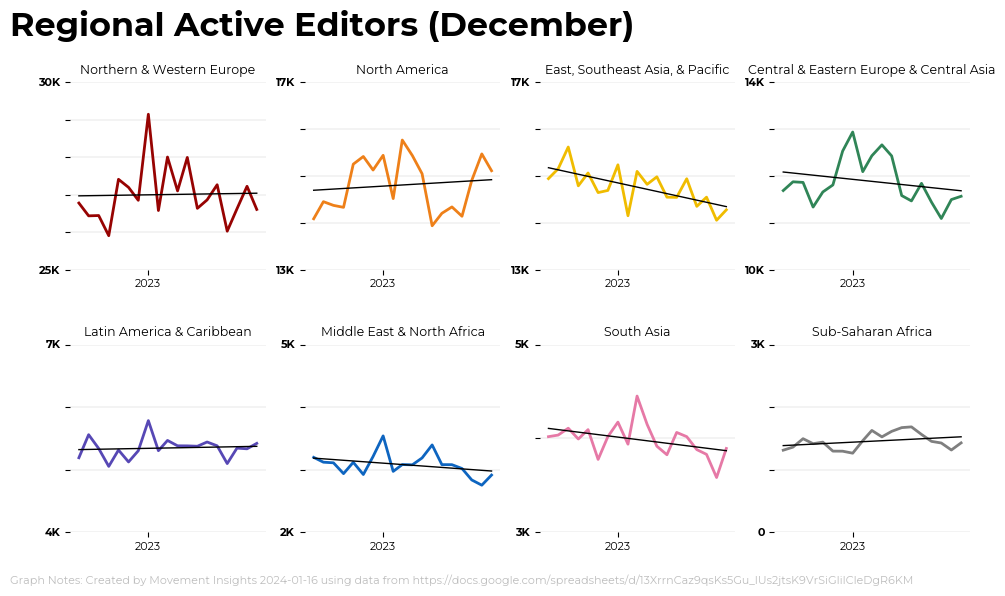

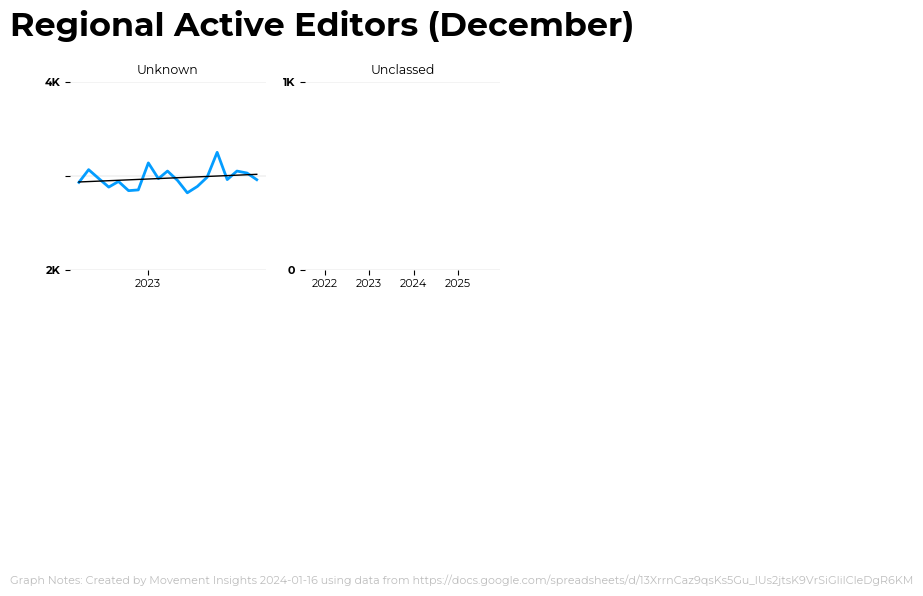

In [4]:
import pandas as pd
from datetime import date, datetime, timedelta
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import os
from os.path import dirname
import warnings
#local
#from wikicharts import Wikichart, wmf_colors, wmf_regions, split_df_by_col, gen_keys, roll
#jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Regional Active Editors chart...")

    warnings.filterwarnings("ignore")

    #---PROMPT FOR INPUT---
    save_file_name_base = "Regional_Active_Editors"
    #note for labeling the YoY highlight
    yoy_note = " "
    #display or note
    display_flag = True

    #---CLEAN DATA--
    #Data Columns: "month", "sum(editors)", wmf_region"
    df = pd.read_csv(home_dir + '/resources/data/regional_editor_metrics.csv')
    #note start and end dates may be different depending on chart_type
    start_date = "2021-07-01"
    end_date = datetime.today()
    #convert string to datetime
    df['month'] = pd.to_datetime(df['month'])
    #truncate data to period of interst
    df = df[df["month"].isin(pd.date_range(start_date, end_date))]
    #fill in NaNs with blanks
    df = df.fillna('')
    #pivot to make regions separate columns
    df = df.rename(columns={'total_active_editors':"monthly_editors"})
    df = df.pivot(index='month', columns='wmf_region', values='monthly_editors').reset_index()
    #rename unknown and unclassed
    df = df.rename(columns={np.nan: "Unknown",'': "Unknown",'UNCLASSED':"Unclassed"})
    #sort columns by total
    #add a Totals row at bottom
    df.loc['Total'] = df.iloc[:, :-1].sum()
    #sort columns left to right for highest to lowest totals
    df = df.sort_values('Total', axis=1, ascending=False)
    #print Totals row (sorted)
    #delete Totals row
    df = df.iloc[:-1]
    #create different dfs for each figure
    max_charts_per_figure = 8
    #split into a dataframe with 8 regions, and another one with the Unknown and Unclassed columns
    df = df.set_index('month')
    dfs = [df[wmf_regions].reset_index(), df[df.columns[~df.columns.isin(wmf_regions)]].reset_index()]
    df = df.reset_index()
    #generate keys that correspond each region to a diff color
    key_colors = [wmf_colors['red'], wmf_colors['orange'], wmf_colors['yellow'], wmf_colors['green'], wmf_colors['purple'], wmf_colors['blue'], wmf_colors['pink'], wmf_colors['black50'], wmf_colors['brightblue']]
    keys = gen_keys(dfs, key_colors)
    

    #---MAKE CHARTS---
    fig_counter = 0
    total_num_charts = len(df.columns) - 1
    num_figures = ceil(total_num_charts / max_charts_per_figure)
    figures = [None] * num_figures

    def round_to_nearest(x, base=1000):
        return base * round(x / base)

    for f in range(num_figures):
        fig_counter += 1
        charts_in_figure = len(dfs[f].columns) - 1
        figures[f] = Wikichart(start_date, end_date, dfs[f])
        figures[f].init_plot(width=12, subplotsx=2, subplotsy=4, fignum=f)
        figures[f].plot_subplots_lines('month', keys[f], num_charts=charts_in_figure, subplot_title_size=9)
        figures[f].plot_multi_trendlines('month', keys[f], num_charts=charts_in_figure)

        # Set individual y-axis limits and labels for each subplot
        for i, ax in enumerate(figures[f].ax.flat):
            if i < charts_in_figure:
                region_label = keys[f].iloc[i]['labelname']
                region_data = dfs[f][region_label].dropna()
                ymin = max(0, round_to_nearest(region_data.min()) - 1000)  # Decrease by 1000 but not below 0
                ymax = round_to_nearest(region_data.max()) + 1000  # Increase by 1000 as a cushion
                ax.set_ylim(ymin, ymax)

                # Generate rounded y-ticks and labels
                y_ticks = np.arange(ymin, ymax + 1000, 1000)  # Adjust step as needed
                y_labels = [f'{int(tick/1000)}k' if tick != 0 else '0' for tick in y_ticks]
                ax.set_yticks(y_ticks)
                ax.set_yticklabels(y_labels)

        figures[f].format_subplots(title='Regional Active Editors',
                                   key=keys[f],
                                   data_source="https://docs.google.com/spreadsheets/d/13XrrnCaz9qsKs5Gu_lUs2jtsK9VrSiGlilCleDgR6KM",
                                   num_charts=charts_in_figure,
                                   tickfontsize=8)
        figures[f].clean_ylabels_subplots(tickfontsize=8)
        save_file_name = save_file_name_base + "_" + str(f) + ".jpeg"
        figures[f].finalize_plot(save_file_name, display=False)
    
if __name__ == "__main__":
    main()